In [1]:

import torch
torch.cuda.is_available()



True

In [2]:
# For Data

from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import CryptoHistoricalDataClient, StockHistoricalDataClient

#from Data.historical_data import Historical_data
import pandas as pd
from Preprocessing.preprocessing import preprocessing
from Models.LSTM.lightningLSTM import LightningLSTM
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from Preprocessing.dataclasses import StockPriceDataModule, StockDataset
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
import matplotlib.pyplot as plt
import numpy as np 


In [3]:
new_data = False

if new_data:

    stocks = [['AAPL'], ['MSFT'], ['GOOG'], ['TSLA'], ['NVDA']]

    for stock in stocks:

        timeframes = [TimeFrame.Day, TimeFrame.Hour, TimeFrame.Minute]
        time_strings = ['Day', 'Hour', 'Minute']

        for timeframe, time_string in zip(timeframes, time_strings):

            s_type = "StockBars"
            stock = stock
            timeframe = timeframe
            start = "2020-08-20 06:00:00"
            end = "2021-08-20 06:00:00"
            client = StockHistoricalDataClient("PKV7BABG3DGE0GYL137W", "af1eQghpVgbyX2lh2T9n2ColmVYXHCWndQbKR3Lr")
            save_csv = True
            time_string = time_string

            df = Historical_data(s_type = s_type, stock = stock, timeframe = timeframe, start = start, end = end, client = client, save_csv = save_csv , time_string = time_string)

else:

    df = pd.read_csv('Data\Stock\StockBars\MSFT_Minute')

In [4]:
data_train, data_test, _ = preprocessing(df = df[:int(len(df)*0.2)], lag = 1, sequence_length=100, dif_all=True, train_size=0.9 )
data_module = StockPriceDataModule(train_sequence = data_train,  test_sequence= data_test, batch_size=64, num_workers = 4)
data_module.setup()

for item in data_module.train_dataloader():
    print(item.keys())
    print(item['sequence'].shape)
    print(item['label'].shape)
    break


dict_keys(['sequence', 'label'])
torch.Size([64, 100, 7])
torch.Size([64])


In [5]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best_checkpoint3",
    save_top_k=1,
    verbose=True,
    monitor="train_loss",
    mode="min"
)

#logger = TensorBoardLogger("logs/", name="lightninglstm")

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

progressbar = TQDMProgressBar(refresh_rate=100)

In [6]:
model = LightningLSTM(input_size=7, hidden_size = 100, num_layers = 3)
trainer = pl.Trainer(max_epochs=15, callbacks=[checkpoint_callback,progressbar], accelerator="gpu", devices=1, limit_val_batches=0)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\lukas\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory C:\Users\lukas\Programmering\Investment AI\Master-Thesis\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model     | LSTM    | 205 K 
1 | criterion | MSELoss | 0     
--------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.821     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 438: 'train_loss' reached 0.25558 (best 0.25558), saving model to 'C:\\Users\\lukas\\Programmering\\Investment AI\\Master-Thesis\\checkpoints\\best_checkpoint3-v11.ckpt' as top 1
Epoch 1, global step 876: 'train_loss' reached 0.25552 (best 0.25552), saving model to 'C:\\Users\\lukas\\Programmering\\Investment AI\\Master-Thesis\\checkpoints\\best_checkpoint3-v11.ckpt' as top 1
Epoch 2, global step 1314: 'train_loss' was not in top 1
Epoch 3, global step 1752: 'train_loss' reached 0.25530 (best 0.25530), saving model to 'C:\\Users\\lukas\\Programmering\\Investment AI\\Master-Thesis\\checkpoints\\best_checkpoint3-v11.ckpt' as top 1
Epoch 4, global step 2190: 'train_loss' was not in top 1
Epoch 5, global step 2628: 'train_loss' was not in top 1
Epoch 6, global step 3066: 'train_loss' was not in top 1
Epoch 7, global step 3504: 'train_loss' was not in top 1
C:\Users\lukas\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: De

2


100%|██████████| 3024/3024 [01:21<00:00, 37.05it/s]


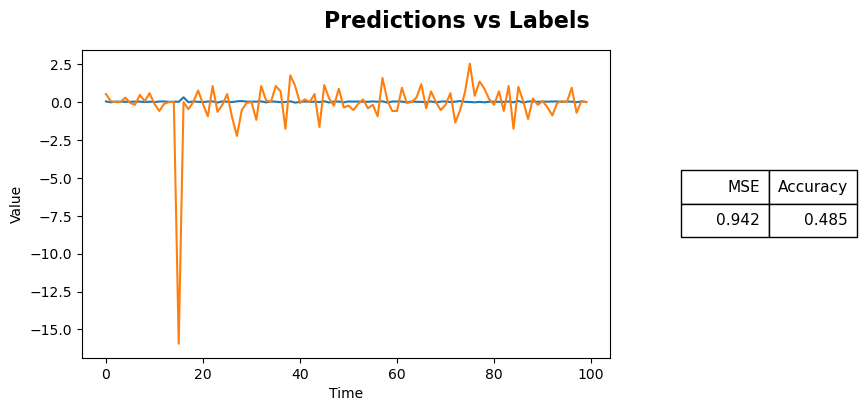

In [ ]:
from Evaluation import evaluation_plots
from tqdm import tqdm
df_test = data_test[:int(len(data_test[0])*0.1)]
print(len(df_test))
test = StockDataset(df_test)

predictions = []
labels = []

pbar = tqdm(total=len(test))

for item in test:
  
  pbar.update(1)
  sequence = item["sequence"]
  label = item['label']

  _, output = model(sequence.unsqueeze(dim=0))
  predictions.append(float(output.detach().numpy()[0]))
  labels.append(float(label.detach().numpy()))

pbar.close()

evaluation_plots.plot_predictions_vs_labels(predictions, labels)